## **Data Loading**

In [4]:
from PIL import Image
import os
from pathlib import Path
import shutil
import filecmp
import matplotlib.pyplot as plt


In [5]:
base_dir = Path("data")
target_dir = base_dir / "images"
target_dir.mkdir(exist_ok=True)

In [6]:
existing_files = {f.name for f in target_dir.iterdir() if f.is_file()}

for folder in base_dir.iterdir():
    if folder.is_dir() and folder.name != "images":
        for image_file in folder.iterdir():
            if image_file.is_file():
                dest_file = target_dir / image_file.name
                if image_file.name not in existing_files:
                    shutil.move(str(image_file), str(dest_file))
                    existing_files.add(image_file.name)
                elif not filecmp.cmp(image_file, dest_file, shallow=False):
                    print(f"Conflict: {image_file} and {dest_file} differ.")


KeyboardInterrupt: 

There are some conflicts but, at the moment, I don't care. As a result, we should have 100k images in the images directory.

All images have format (1280, 720).

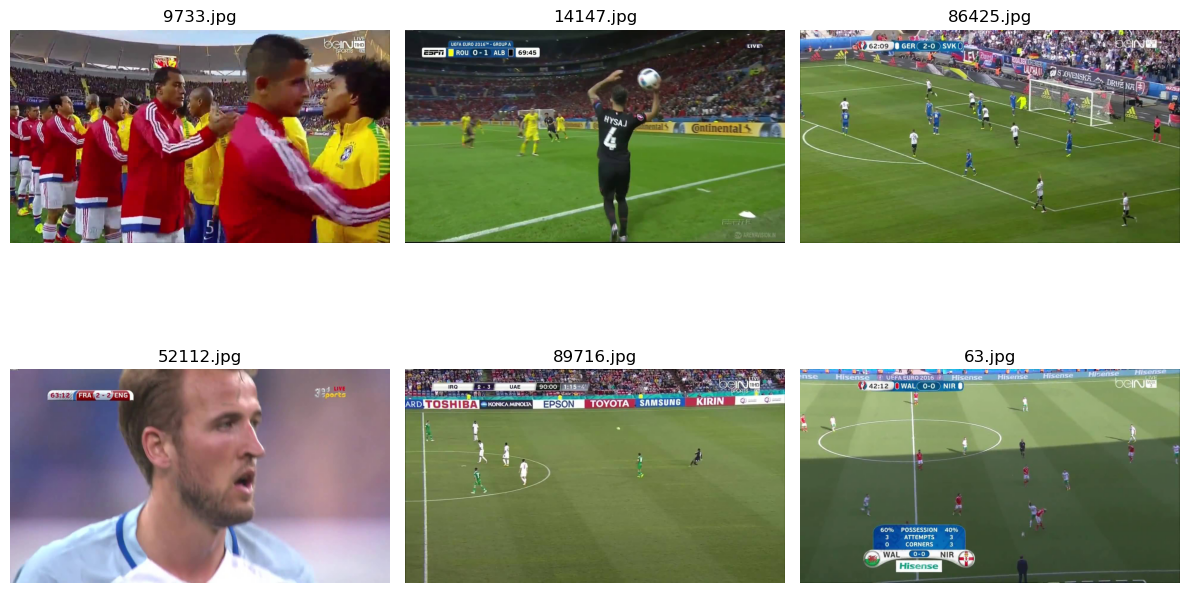

In [6]:
image_files = list(image_dir.glob("*.*"))[:6]  # Adjust number as needed

# Plot images
plt.figure(figsize=(12, 8))

for i, img_path in enumerate(image_files):
    try:
        img = Image.open(img_path)
        plt.subplot(2, 3, i + 1)  # 2 rows, 3 columns
        plt.imshow(img)
        plt.title(img_path.name)
        plt.axis("off")
    except Exception as e:
        print(f"Failed to load {img_path.name}: {e}")

plt.tight_layout()
plt.show()

## Preprocessing

In [7]:
# open excel labels
import pandas as pd

labels_df = pd.read_excel('labels.xlsx')


In [8]:
# from second column, rename column name with the strings in the first row
def rename_columns(df):
    new_columns = df.iloc[0]
    df.columns = new_columns
    df = df[1:]
    return df

labels_df = rename_columns(labels_df)

In [9]:
# drop the first column
labels_df = labels_df.drop(labels_df.columns[0], axis=1)

In [10]:
labels_df.head()

,Gate,Start/Restar the game,The joy of the players,yellow card,Red Card,Ball,Stadium View,referee Image,Penalty Image,Free Kick
1,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,1,1,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0
5,0,0,0,0,0,1,0,1,0,0


In [11]:
labels_df.columns

Index(['Gate ', 'Start/Restar the game', 'The joy of the players',
       'yellow card', 'Red Card', 'Ball', 'Stadium View', 'referee Image',
       'Penalty Image', 'Free Kick'],
      dtype='object', name=0)

In [12]:
for i in labels_df.columns:
    print(labels_df[i].value_counts())

Gate 
0     75991
1     24007
11        2
Name: count, dtype: int64
Start/Restar the game
0    99431
1      569
Name: count, dtype: int64
The joy of the players
0    98625
1     1375
Name: count, dtype: int64
yellow card
0    99409
1      591
Name: count, dtype: int64
Red Card
0    99929
1       71
Name: count, dtype: int64
Ball
0     52311
1     47687
11        2
Name: count, dtype: int64
Stadium View
0    95884
1     4116
Name: count, dtype: int64
referee Image
0     64643
1     35352
11        4
          1
Name: count, dtype: int64
Penalty Image
0    99460
1      540
Name: count, dtype: int64
Free Kick
0     97441
1      2557
11        2
Name: count, dtype: int64


Since there are some typos where in some cells there is written 11 instead of 1, I correct them.

In [13]:
for i in labels_df.columns:
    labels_df[i] = labels_df[i].replace(11, 1)

labels_df['referee Image'] = labels_df['referee Image'].replace(' ',0)

/var/folders/r9/tk3nsgjj4_j4z3n_rxsd7s580000gn/T/ipykernel_34821/1875788819.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labels_df[i] = labels_df[i].replace(11, 1)
/var/folders/r9/tk3nsgjj4_j4z3n_rxsd7s580000gn/T/ipykernel_34821/1875788819.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labels_df['referee Image'] = labels_df['referee Image'].replace(' ',0)


## Mutually exclusive events

In [14]:
# drop some columns
subset = labels_df.drop(columns=['Gate ', 'Ball', 'yellow card', 'Red Card', 'referee Image'])
# add a column to subset with the sum of the values in the other columns
subset['sum'] = subset.sum(axis=1)

subset['sum'].value_counts()

sum
0    91752
1     7338
2      909
3        1
Name: count, dtype: int64

In [15]:
subset[subset['sum'] == 3]

,Start/Restar the game,The joy of the players,Stadium View,Penalty Image,Free Kick,sum
54828,0,0,1,1,1,3


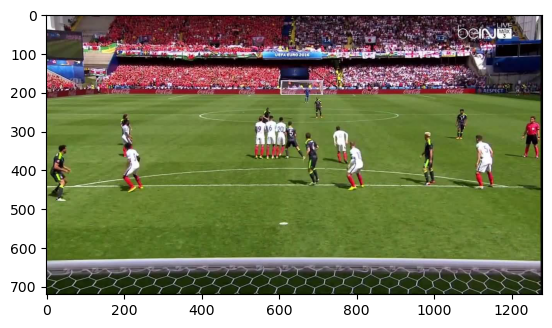

In [16]:
# display image 54828
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('data/images/54828.jpg')
plt.imshow(img)

This is a free kick not a penalty kick, should I correct the label?


In [17]:
# check which labels that sum to 2 are 1

subset[subset['sum'] == 2]

,Start/Restar the game,The joy of the players,Stadium View,Penalty Image,Free Kick,sum
7999,1,0,1,0,0,2
8000,1,0,1,0,0,2
8010,1,0,1,0,0,2
8019,1,0,1,0,0,2
10336,0,1,1,0,0,2
...,...,...,...,...,...,...
99825,1,0,1,0,0,2
99827,1,0,1,0,0,2
99828,1,0,1,0,0,2
99855,0,0,1,0,1,2


In [18]:
# drop some columns
subset2 = labels_df.drop(columns=['Gate ', 'Ball', 'referee Image', 'Start/Restar the game'])
subset2['sum'] = subset2.sum(axis=1)
subset2['sum'].value_counts()

sum
0    91420
1     7910
2      668
3        2
Name: count, dtype: int64

What if i consider also red and yellow card?

In [19]:
# drop some columns
subset3 = labels_df.drop(columns=['Gate ', 'Ball', 'referee Image'])

In [20]:
# add a column to subset with the sum of the values in the other columns
subset3['sum'] = subset3.sum(axis=1)
subset3['sum'].value_counts()

sum
0    91095
1     7991
2      912
3        2
Name: count, dtype: int64

Looking at the value counts almost all the new labeled images taken into consideration (red, yellow card) are mutually exclusive so we include them.

In [21]:
# take a sample of 2009 instances where 'sum' is 0
no_label = subset3[subset3['sum']==0]
no_label_sample = no_label.sample(n=2009, random_state=42)


In [22]:

# take only entries where 'sum' is 1
mutually_exclusive = subset3[subset3['sum']==1]
mutually_exclusive

,Start/Restar the game,The joy of the players,yellow card,Red Card,Stadium View,Penalty Image,Free Kick,sum
1,0,0,0,0,1,0,0,1
2,0,0,0,0,1,0,0,1
94,0,0,1,0,0,0,0,1
95,0,0,1,0,0,0,0,1
96,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...
99800,1,0,0,0,0,0,0,1
99840,0,0,0,0,1,0,0,1
99841,0,0,0,0,1,0,0,1
99856,0,0,0,0,0,0,1,1


In [23]:
mutually_exclusive = pd.concat([mutually_exclusive, no_label_sample], ignore_index=False)
# create a new column from the index
mutually_exclusive['Image Number'] = mutually_exclusive.index 
# I want it to be the first column
mutually_exclusive = mutually_exclusive[['Image Number'] + [col for col in mutually_exclusive.columns if col != 'Image Number']]
mutually_exclusive

,Image Number,Start/Restar the game,The joy of the players,yellow card,Red Card,Stadium View,Penalty Image,Free Kick,sum
1,1,0,0,0,0,1,0,0,1
2,2,0,0,0,0,1,0,0,1
94,94,0,0,1,0,0,0,0,1
95,95,0,0,1,0,0,0,0,1
96,96,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
88281,88281,0,0,0,0,0,0,0,0
35162,35162,0,0,0,0,0,0,0,0
47062,47062,0,0,0,0,0,0,0,0
83692,83692,0,0,0,0,0,0,0,0


In [24]:
# create a new column 'Generic Moment' which is initialized to 0
mutually_exclusive['Generic Moment'] = 0
# where sum == 0, set Generic Moment to 1
mutually_exclusive.loc[mutually_exclusive['sum'] == 0, 'Generic Moment'] = 1
mutually_exclusive = mutually_exclusive.drop(columns=['sum'])
mutually_exclusive


,Image Number,Start/Restar the game,The joy of the players,yellow card,Red Card,Stadium View,Penalty Image,Free Kick,Generic Moment
1,1,0,0,0,0,1,0,0,0
2,2,0,0,0,0,1,0,0,0
94,94,0,0,1,0,0,0,0,0
95,95,0,0,1,0,0,0,0,0
96,96,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
88281,88281,0,0,0,0,0,0,0,1
35162,35162,0,0,0,0,0,0,0,1
47062,47062,0,0,0,0,0,0,0,1
83692,83692,0,0,0,0,0,0,0,1


In [25]:
# based on the index of mutually_exclusive I want to take the same rows from the original labels_df
selected_labels = labels_df.loc[mutually_exclusive.index]
selected_labels['Generic Moment'] = mutually_exclusive['Generic Moment']
selected_labels.head()

,Gate,Start/Restar the game,The joy of the players,yellow card,Red Card,Ball,Stadium View,referee Image,Penalty Image,Free Kick,Generic Moment
1,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,1,1,0,0,0
94,0,0,0,1,0,1,0,1,0,0,0
95,0,0,0,1,0,1,0,1,0,0,0
96,0,0,0,1,0,1,0,1,0,0,0


In [26]:
# rename 'Gate ' to 'Gate'
selected_labels = selected_labels.rename(columns={'Gate ': 'Gate'})

In [27]:
# create a column 'Image Number' which is the index of the dataframe
selected_labels['Image Number'] = selected_labels.index
# reorder the columns
selected_labels = selected_labels[['Image Number'] + [col for col in selected_labels.columns if col != 'Image Number']]
selected_labels.head()

,Image Number,Gate,Start/Restar the game,The joy of the players,yellow card,Red Card,Ball,Stadium View,referee Image,Penalty Image,Free Kick,Generic Moment
1,1,0,0,0,0,0,0,1,0,0,0,0
2,2,0,0,0,0,0,0,1,1,0,0,0
94,94,0,0,0,1,0,1,0,1,0,0,0
95,95,0,0,0,1,0,1,0,1,0,0,0
96,96,0,0,0,1,0,1,0,1,0,0,0


In [28]:
selected_labels.to_csv('selected_labels.csv', index=False)

In [29]:
images = selected_labels.index.to_list()
len(images)

10000

In [30]:

# create a new folder for the cropped images
cropped_images_dir = Path("data/selected_images")
cropped_images_dir.mkdir(exist_ok=True)
# copy the images to the new folder
for image in images:
    src = target_dir / f"{image}.jpg"
    dst = cropped_images_dir / f"{image}.jpg"
    shutil.copy(src, dst)



Now I check that each label is balanced

In [33]:
selected_labels2 = selected_labels[['Start/Restar the game', 'The joy of the players', 'yellow card', 'Red Card', 'Stadium View', 'Penalty Image', 'Free Kick', 'Generic Moment']]
selected_labels2['sum'] = selected_labels2.sum(axis=1)
selected_labels2['sum'].value_counts()

/var/folders/r9/tk3nsgjj4_j4z3n_rxsd7s580000gn/T/ipykernel_34821/2824170426.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_labels2['sum'] = selected_labels2.sum(axis=1)


sum
1    10000
Name: count, dtype: int64

This checks that all the images pertain to 1 and only 1 class, and it is the case because we have 10000 instances that sum to 1.

In [31]:
for i in selected_labels.columns:
    print(selected_labels[i].value_counts())

Image Number
1        1
82990    1
82968    1
82969    1
82971    1
        ..
43294    1
43295    1
43296    1
43297    1
87448    1
Name: count, Length: 10000, dtype: int64
Gate
0    5850
1    4150
Name: count, dtype: int64
Start/Restar the game
0    9675
1     325
Name: count, dtype: int64
The joy of the players
0    8671
1    1329
Name: count, dtype: int64
yellow card
0    9414
1     586
Name: count, dtype: int64
Red Card
0    9930
1      70
Name: count, dtype: int64
Ball
0    5780
1    4220
Name: count, dtype: int64
Stadium View
0    6791
1    3209
Name: count, dtype: int64
referee Image
0    6746
1    3254
Name: count, dtype: int64
Penalty Image
0    9548
1     452
Name: count, dtype: int64
Free Kick
0    7980
1    2020
Name: count, dtype: int64
Generic Moment
0    7991
1    2009
Name: count, dtype: int64


From what I see only the situations of 'Start/Restar the game', 'yellow card', 'Red Card' and 'Penalty Image' seem to have less instances but we cannot do much about them because we've taken all the instances from the original dataset. Actually it can make sense because those are moments that happen less frequently during a football match.